### GM sensitivity in BMOM

This notebooks documents the effects of doubling MEKE_GEOMETRIC_ALPHA in BMOM.

#### Simulations:

* Case1 - bmom.e23.f09_t061_zstar_N65.nuopc.enthalpy_via_cpl.002 (MEKE_GEOMETRIC_ALPHA = 0.07)
* Case 2 - bmom.e23.f09_t061_zstar_N65.nuopc.GM_tuning.001 ((MEKE_GEOMETRIC_ALPHA = 0.14))

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import warnings, os, glob
from mom6_tools.MOM6grid import MOM6grid
from mom6_tools.m6toolbox import genBasinMasks
from mom6_tools.m6plot import ztplot, xyplot, yzplot, chooseColorLevels
import pop_tools
warnings.filterwarnings("ignore")
matplotlib.rcParams.update({'font.size': 14})
%matplotlib inline

Basemap module not found. Some regional plots may not function properly


In [2]:
from distributed import Client
from ncar_jobqueue import NCARCluster

cluster = NCARCluster()
cluster.scale(6)
client = Client(cluster)
client

<Client: 'tcp://10.12.206.36:42167' processes=0 threads=0, memory=0 B>

In [3]:
path = '/glade/scratch/gmarques/'
exps = ['bmom.e23.f09_t061_zstar_N65.nuopc.enthalpy_via_cpl.002',
        'bmom.e23.f09_t061_zstar_N65.nuopc.GM_tuning.001']
labels = ['case1', 'case2']

start = '0001-01-01'
end = '0020-12-31'

# set this to true to save the plots
saveplot = False
if saveplot:
    os.system('mkdir PNG')

In [4]:
# load grid and pre-difined masks
grd = MOM6grid(path+exps[0]+'/run/'+exps[0]+'.mom6.static.nc')
depth = grd.depth_ocean
# remote Nan's, otherwise genBasinMasks won't work
depth[np.isnan(depth)] = 0.0
basin_code = genBasinMasks(grd.geolon, grd.geolat, depth, xda=True)

MOM6 grid successfully loaded... 

11.16428 64.78855 [391, 434]


### Globally-averaged ocean properties

../../bmom.e23.f09_t061_zstar_N65.nuopc.enthalpy_via_cpl.002/ncfiles/bmom.e23.f09_t061_zstar_N65.nuopc.enthalpy_via_cpl.002_mon_ave_global_means.nc
../../bmom.e23.f09_t061_zstar_N65.nuopc.GM_tuning.001/ncfiles/bmom.e23.f09_t061_zstar_N65.nuopc.GM_tuning.001_mon_ave_global_means.nc


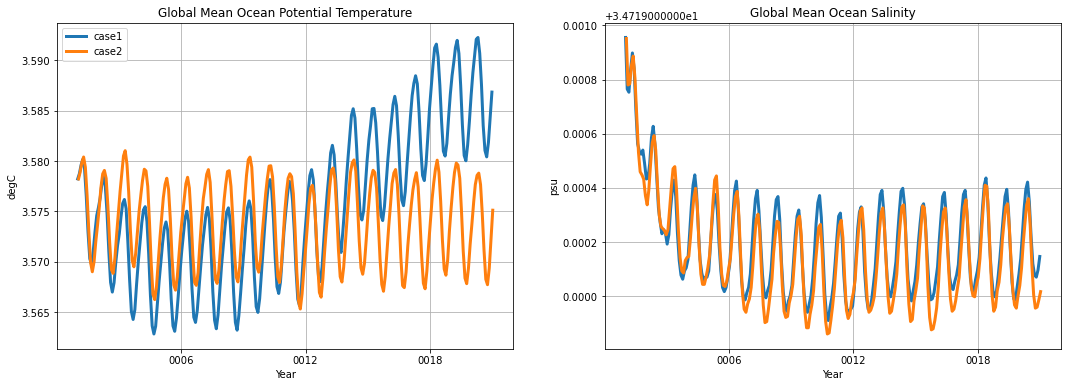

In [12]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
variables = ['thetaoga', 'soga']
for i in range(len(exps)):
  tmp = '../../'+exps[i]+'/ncfiles/'+exps[i]+'_mon_ave_global_means.nc'
  print(tmp)
  ds = xr.open_dataset(tmp).sel(time=slice(start,end))
  ds['thetaoga'].plot(ax=ax[0], label=labels[i], lw=3)
  ds['soga'].plot(ax=ax[1], lw=3)

ax[0].set_title(ds.thetaoga.attrs['long_name']); ax[0].set_ylabel(ds.thetaoga.attrs['units'])
ax[1].set_title(ds.soga.attrs['long_name']); ax[1].set_ylabel(ds.soga.attrs['units'])
ax[0].legend()
ax[0].set_xlabel('Year')
ax[1].set_xlabel('Year')
ax[0].grid(); ax[1].grid()
if saveplot:
    fname = 'PNG/global_means.png'
    plt.savefig(fname, bbox_inches='tight',dpi=300)

### Transports

In [6]:
ds = xr.open_dataset('../../'+exps[0]+'/ncfiles/'+exps[0]+'_section_transports.nc')

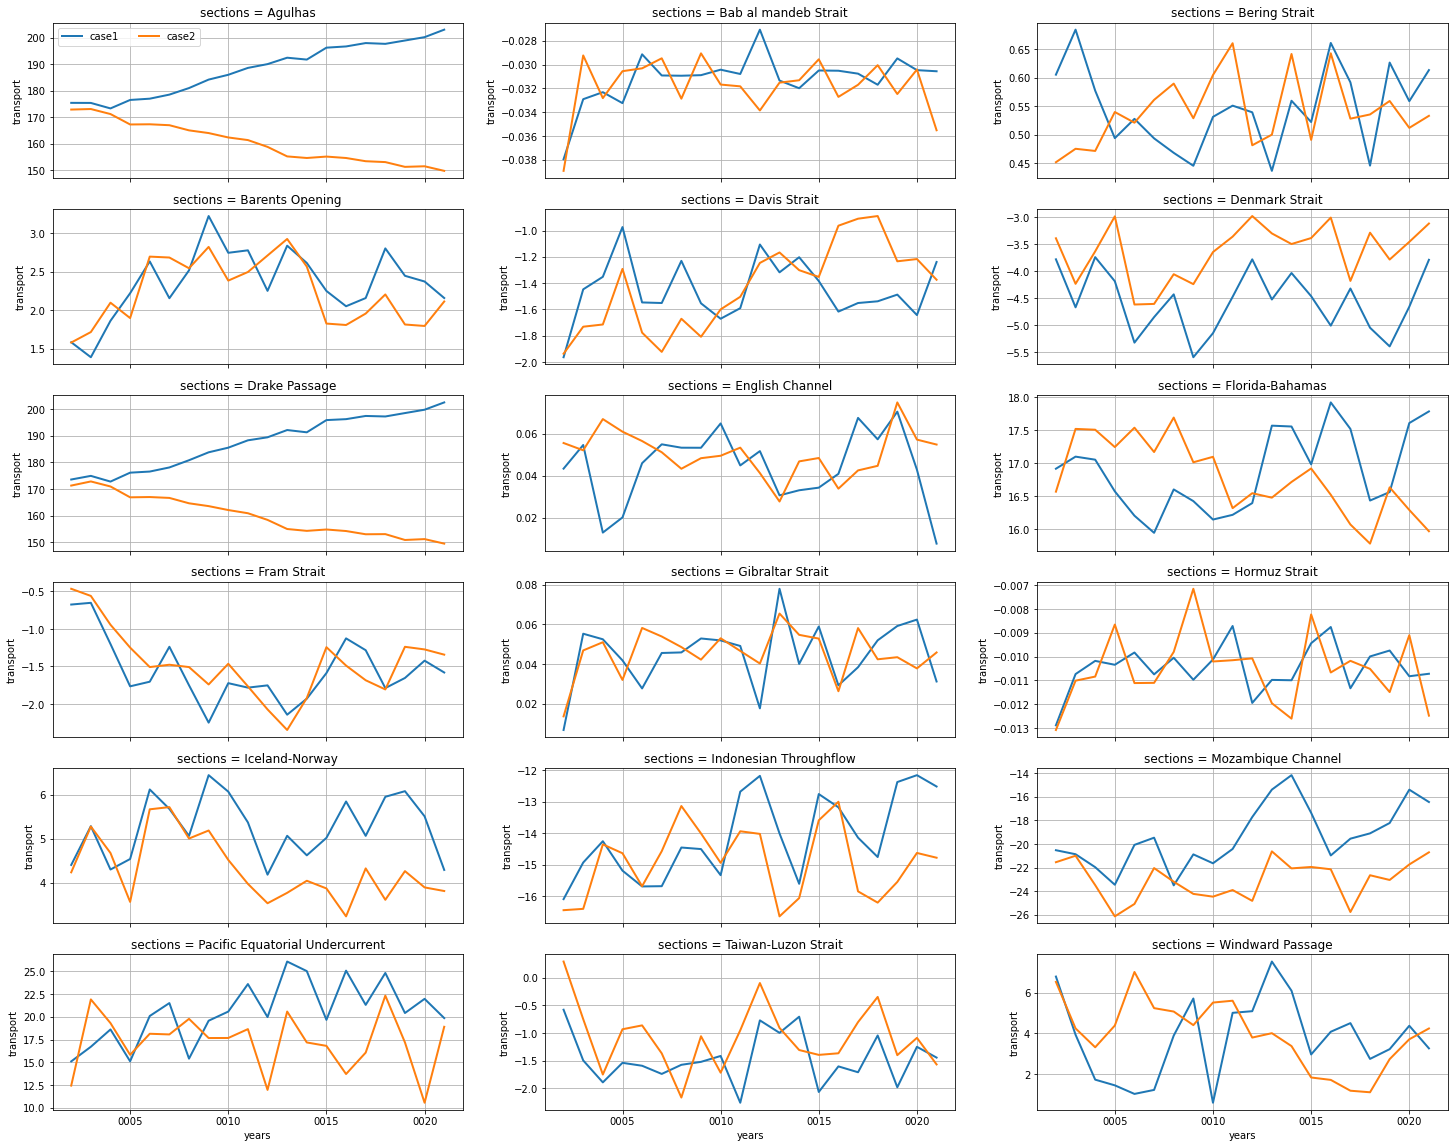

In [7]:
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(25,20), sharex=True)
ax1 = ax.flatten()
for p in range(len(ds.sections)):
  for i in range(len(exps)):
    ds1 = xr.open_dataset('../../'+exps[i]+'/ncfiles/'+exps[i]+'_section_transports.nc')
    ds = ds1.sel(time=slice(start, end))
    ds.transport.isel(sections=p).plot(ax=ax1[p], label=labels[i], lw=2)
  ax1[p].set_xlabel('')
  ax1[p].grid()
    
ax1[0].legend(ncol=4)
for i in [-3, -2, -1]:
  ax1[i].set_xlabel('years')

Text(0, 0.5, 'Transport [Sv]')

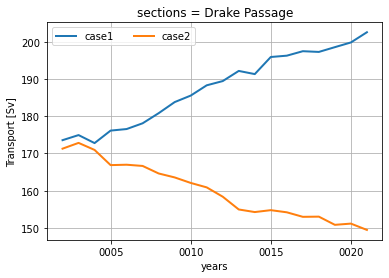

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1)
for i in range(len(exps)):
    ds1 = xr.open_dataset('../../'+exps[i]+'/ncfiles/'+exps[i]+'_section_transports.nc')
    ds = ds1.sel(time=slice(start, end))
    ds.transport.isel(sections=6).plot(ax=ax, label=labels[i], lw=2)
  
ax.grid()
ax.legend(ncol=4)
ax.set_xlabel('years')
ax.set_ylabel('Transport [Sv]')

### GM coefficient

In [9]:
def preprocess(ds):
  variables = ['diftrblo', 'difmxylo' ,'difmxybo', 'diftrelo', 'e']
  return ds[variables].sel(time=slice(start, end))

ds1 = []
for i in range(2):
  print(i)
  files = sorted(glob.glob(path+exps[i]+'/run/'+exps[i]+'.mom6.hm_*.nc'))#[0:-1]

  ds = xr.open_mfdataset(files,
        parallel=True,
        concat_dim="time",
        combine="nested",
        preprocess=preprocess,
        chunks={'time': 1},)
    
  ds1.append(ds.mean(dim='time').compute())

0
1


In [24]:
variables = ['diftrblo', 'difmxylo' ,'difmxybo', 'diftrelo', 'e']

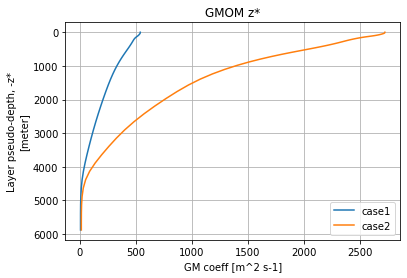

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ds1[0]['diftrblo'].sel(yh=slice(-65, 
        -55)).mean(dim=['xh','yh']).plot(ax=ax,y="zl", label=labels[0])
ds1[1]['diftrblo'].sel(yh=slice(-65, 
        -55)).mean(dim=['xh','yh']).plot(ax=ax,y="zl", label=labels[1])
ax.grid()
ax.legend()
ax.set_xlabel('GM coeff [m^2 s-1]')
ax.set_title('GMOM z*')
plt.gca().invert_yaxis()

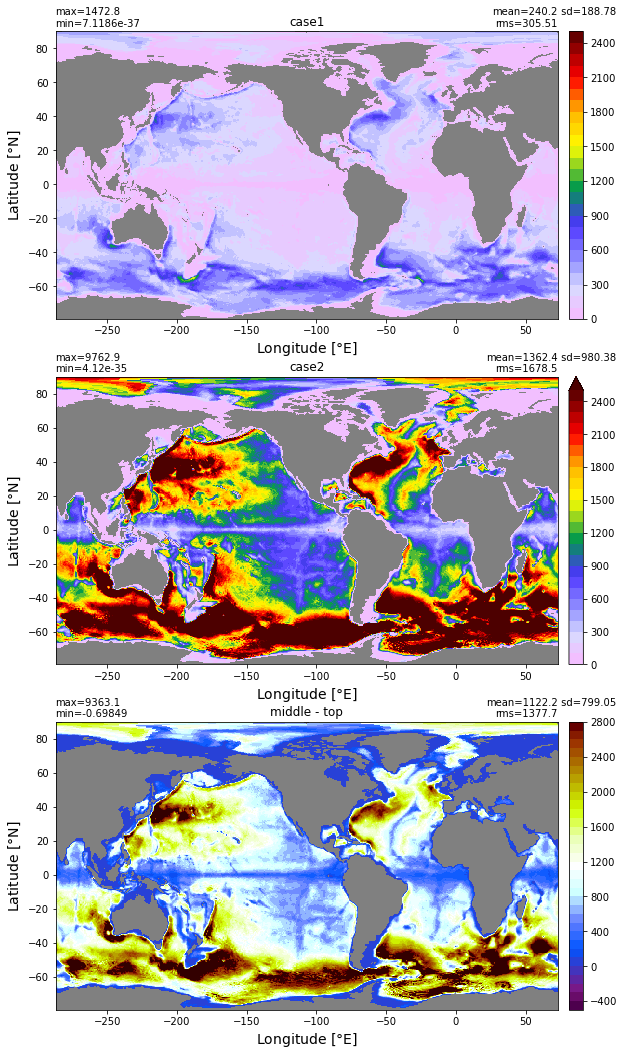

In [30]:
# GM coefficient
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,18))

top = np.ma.masked_invalid(ds1[0][variables[0]][0,:].values)
middle = np.ma.masked_invalid(ds1[1][variables[0]][0,:].values)
bottom = middle - top
xyplot(top, grd.geolon, grd.geolat, area=grd.area_t, clim=(0,2500), 
       title=str(labels[0]),axis=ax[0])
xyplot(middle, grd.geolon, grd.geolat, area=grd.area_t, clim=(0,2500), 
       title=str(labels[1]),axis=ax[1])
xyplot(bottom, grd.geolon, grd.geolat, area=grd.area_t,  
       title='middle - top',axis=ax[2])

### Horizontal Mean bias versus time

Potential Temperature bias [C], (model - obs)


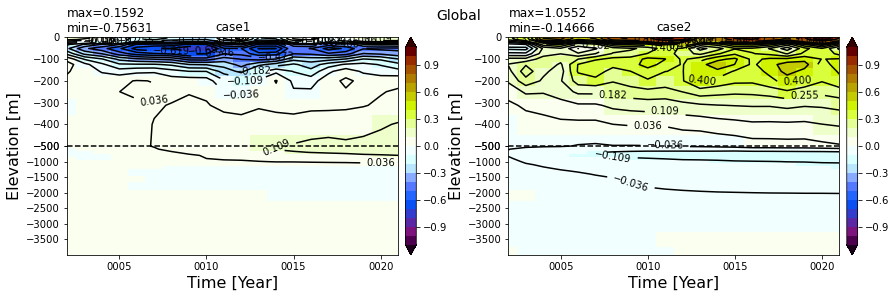

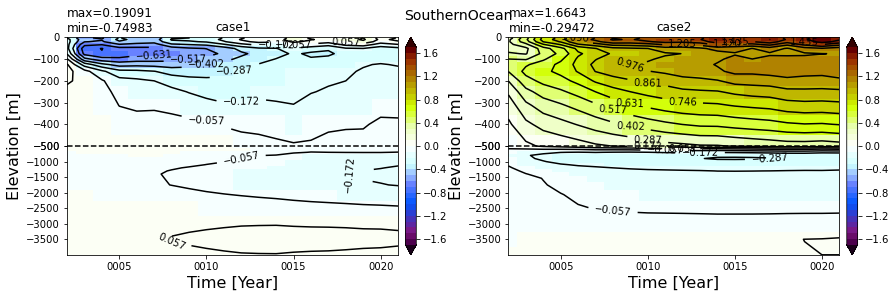

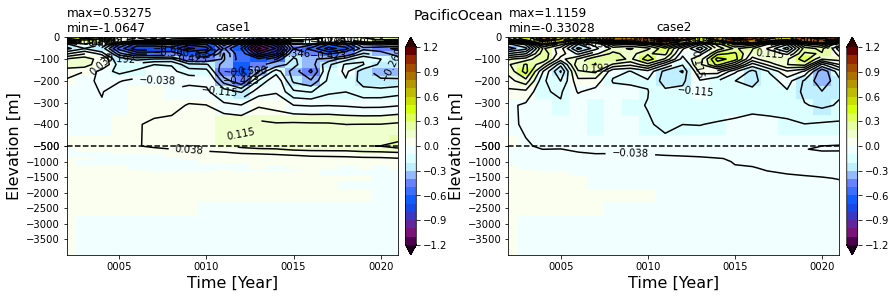

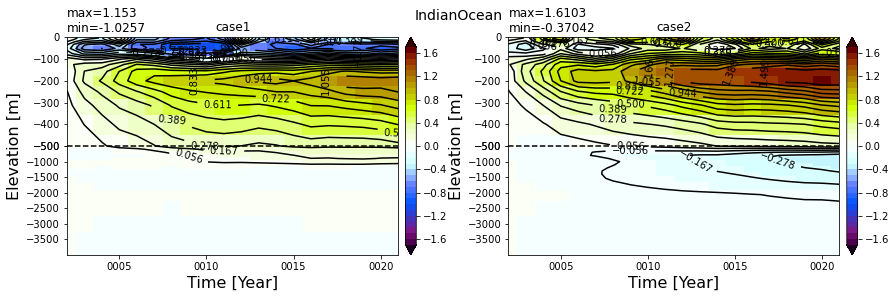

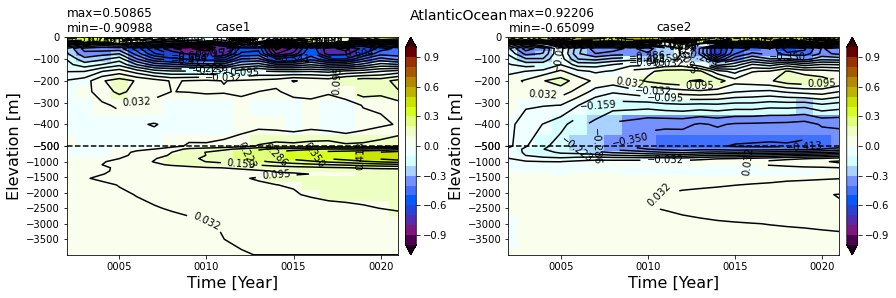

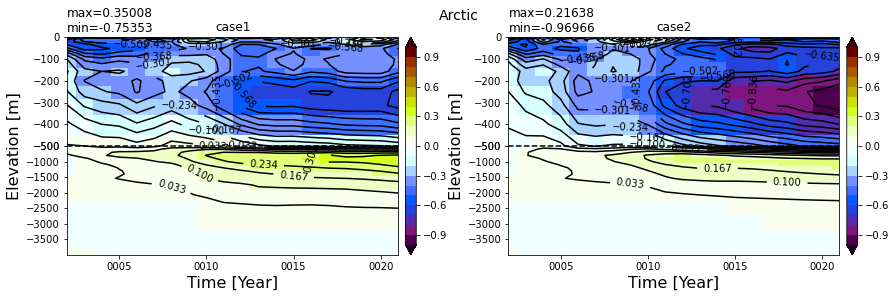

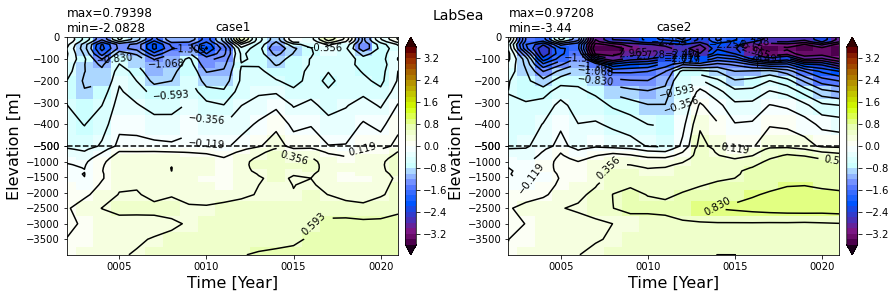

In [21]:
%matplotlib inline
reg_mom = ['Global','SouthernOcean','PacificOcean','IndianOcean','AtlanticOcean',
           'Arctic','LabSea']
reg_pop = [0,1,2,3,6,10,8]

path1='../../'+exps[0]+'/ncfiles/'+exps[0]+'_temp_bias.nc'
ds_mom1 = xr.open_dataset(path1).sel(time=slice(start, end)) 
path2='../../'+exps[1]+'/ncfiles/'+exps[1]+'_temp_bias.nc'
ds_mom2 = xr.open_dataset(path2).sel(time=slice(start, end))  

print('Potential Temperature bias [C], (model - obs)')
for m,p in zip(reg_mom,reg_pop):
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14.5,4))
  plt.suptitle(str(m), fontsize=14)
  splitscale =  [0., -500., -4000]
  dummy_mom1 = np.ma.masked_invalid(ds_mom1.sel(region=m).temp_bias.values)
  dummy_mom2 = np.ma.masked_invalid(ds_mom2.sel(region=m).temp_bias.values)
  
  cmax = np.max([np.max(np.abs(dummy_mom1)), np.max(np.abs(dummy_mom2))])
  clim = (-cmax, cmax)
  clevs = np.linspace(-cmax,cmax,30)
  ztplot(dummy_mom1, ds_mom1.time.values, ds_mom1.z_l.values*-1, ignore=np.nan, splitscale=splitscale, 
         contour=True, axis=ax.flat[0] , title=labels[0], extend='both', colormap='dunnePM', 
         autocenter=True, tunits='Year', clim=clim, clevs=clevs) 

  ztplot(dummy_mom2, ds_mom2.time.values, ds_mom2.z_l.values*-1, ignore=np.nan, splitscale=splitscale, 
         contour=True, axis=ax.flat[1] , title=labels[1], extend='both', colormap='dunnePM', 
         autocenter=True, tunits='Year', clim=clim, clevs=clevs)

Salinity bias [psu], (model - obs)


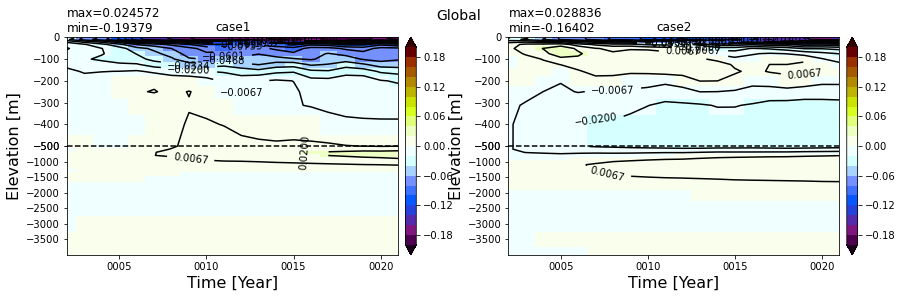

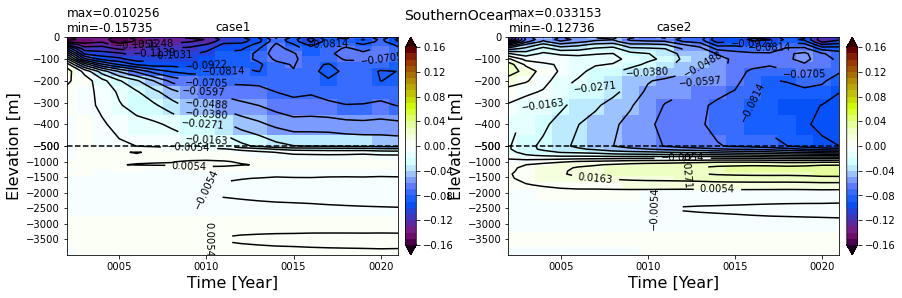

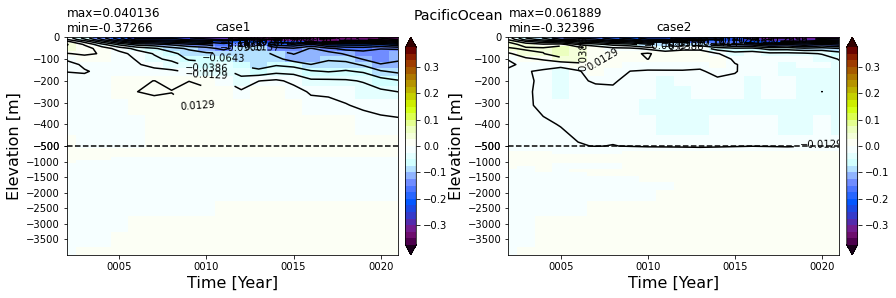

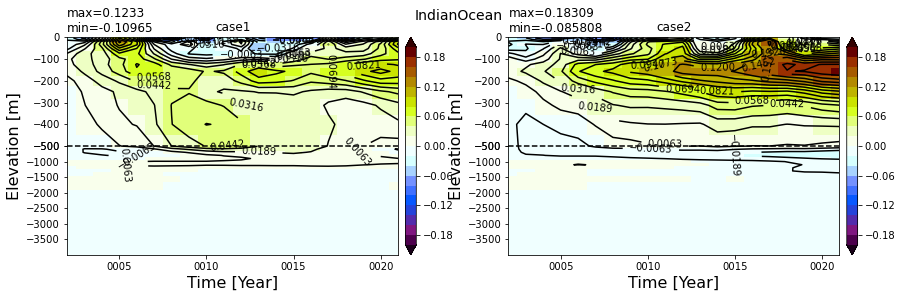

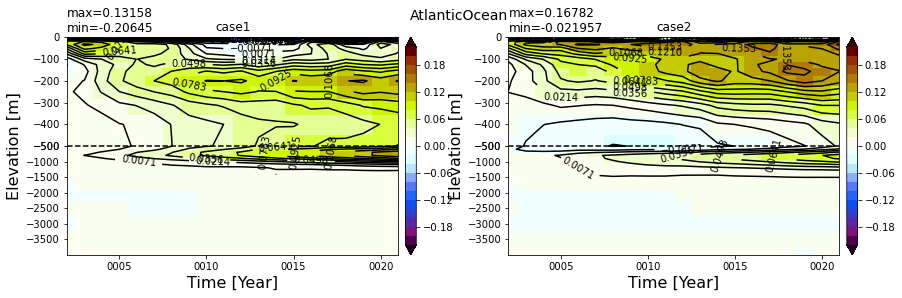

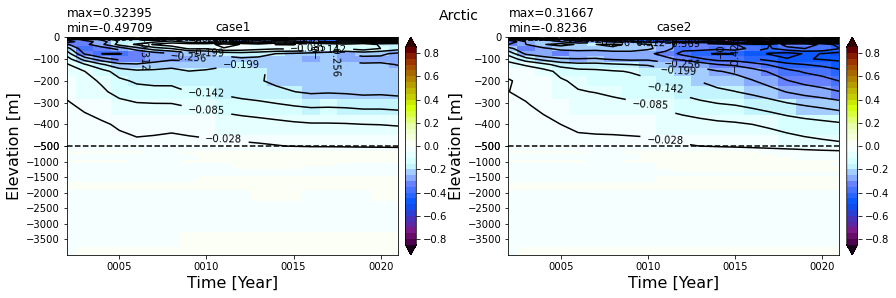

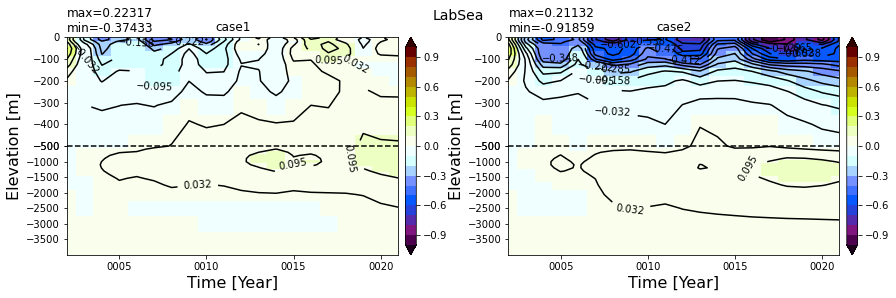

In [24]:
%matplotlib inline
reg_mom = ['Global','SouthernOcean','PacificOcean','IndianOcean','AtlanticOcean','Arctic','LabSea']
reg_pop = [0,1,2,3,6,10,8]

path1='../../'+exps[0]+'/ncfiles/'+exps[0]+'_salt_bias.nc'
ds_mom1 = xr.open_dataset(path1).sel(time=slice(start, end))
path2='../../'+exps[1]+'/ncfiles/'+exps[1]+'_salt_bias.nc'
ds_mom2 = xr.open_dataset(path2).sel(time=slice(start, end))

print('Salinity bias [psu], (model - obs)')
for m,p in zip(reg_mom,reg_pop):
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14.5,4.))
  plt.suptitle(str(m), fontsize=14)
  splitscale =  [0., -500., -4000]
  dummy_mom1 = np.ma.masked_invalid(ds_mom1.sel(region=m).salt_bias.values)
  dummy_mom2 = np.ma.masked_invalid(ds_mom2.sel(region=m).salt_bias.values)
  
 
  cmax = np.max([np.max(np.abs(dummy_mom1)), np.max(np.abs(dummy_mom2))])
  clim = (-cmax, cmax)
  clevs = np.linspace(-cmax,cmax,30)

  ztplot(dummy_mom1, ds_mom1.time.values, ds_mom1.z_l.values*-1, ignore=np.nan, splitscale=splitscale, 
         contour=True, axis=ax.flat[0] , title=labels[0], extend='both', colormap='dunnePM', 
         autocenter=True, tunits='Year', clim=clim, clevs=clevs) 

  ztplot(dummy_mom2, ds_mom2.time.values, ds_mom2.z_l.values*-1, ignore=np.nan, splitscale=splitscale, 
         contour=True, axis=ax.flat[1] , title=labels[1], extend='both', colormap='dunnePM', 
         autocenter=True, tunits='Year', clim=clim, clevs=clevs)

### T/S difference at selected vertical levels

In [44]:
def preprocess(ds):
  ''' Compute montly averages and return the dataset with variables'''
  variables=['thetao','so']
  return ds[variables].sel(time=slice(start, end))

files = sorted(glob.glob(path+exps[0]+'/run/'+exps[0]+'.mom6.h_*.nc'))
ds1 = xr.open_mfdataset(files,
        parallel=True,
        concat_dim="time",
        combine="nested",
        preprocess=preprocess,
        chunks={'time': 1},).mean('time').compute()
    
files = sorted(glob.glob(path+exps[1]+'/run/'+exps[1]+'.mom6.h_*.nc'))
ds2 = xr.open_mfdataset(files,
        parallel=True,
        concat_dim="time",
        combine="nested",
        preprocess=preprocess,
        chunks={'time': 1},).mean('time').compute()

In [45]:
ds1

<xarray.Dataset>
Dimensions:  (z_l: 34, yh: 458, xh: 540)
Coordinates:
  * yh       (yh) float64 -79.2 -79.08 -78.95 -78.82 ... 87.55 87.64 87.71 87.74
  * z_l      (z_l) float64 2.5 10.0 20.0 32.5 ... 4.5e+03 5e+03 5.5e+03 6e+03
  * xh       (xh) float64 -286.7 -286.0 -285.3 -284.7 ... 70.67 71.33 72.0 72.67
Data variables:
    thetao   (z_l, yh, xh) float32 nan nan nan nan nan ... nan nan nan nan nan
    so       (z_l, yh, xh) float32 nan nan nan nan nan ... nan nan nan nan nan

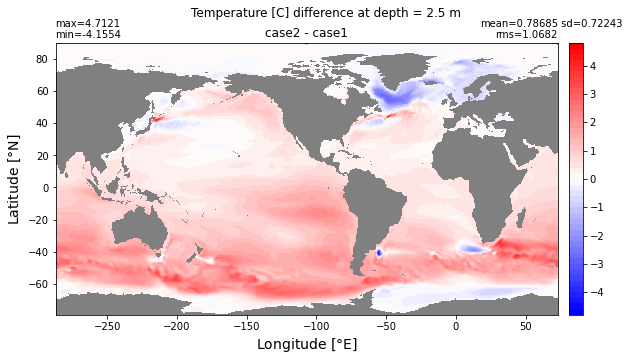

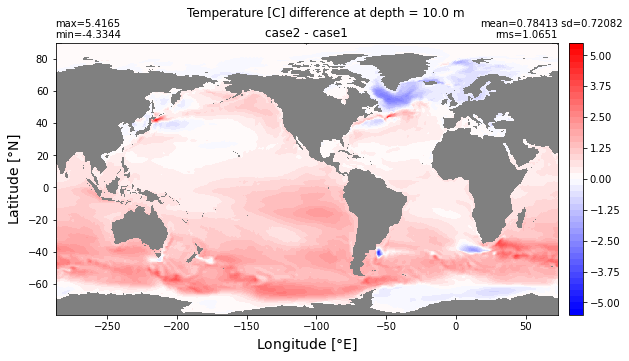

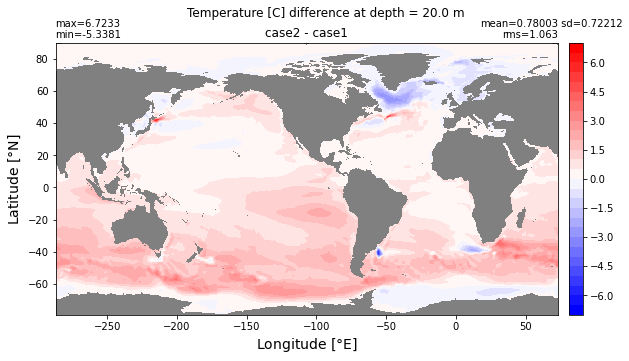

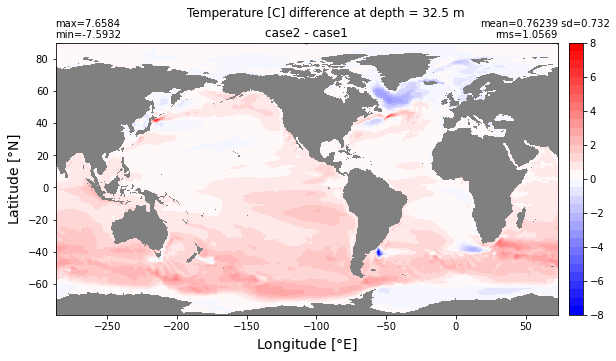

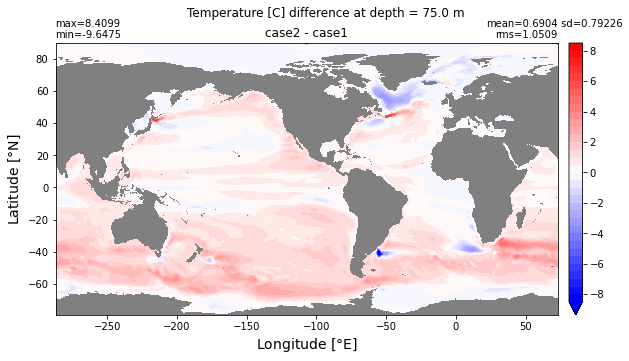

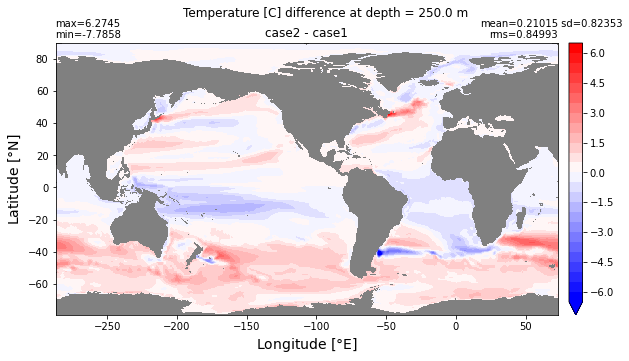

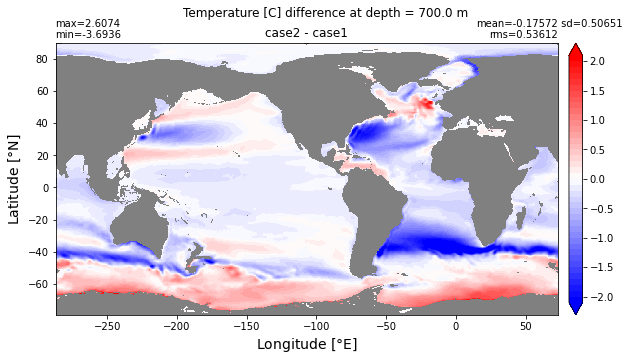

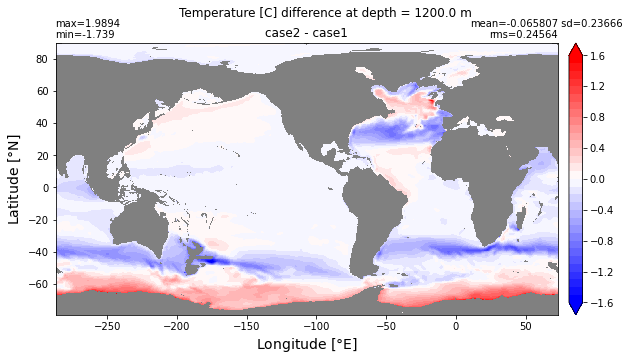

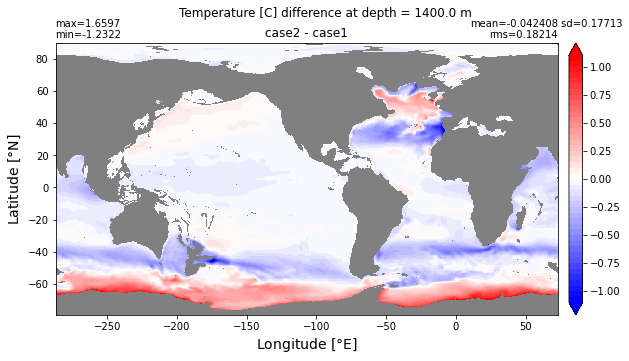

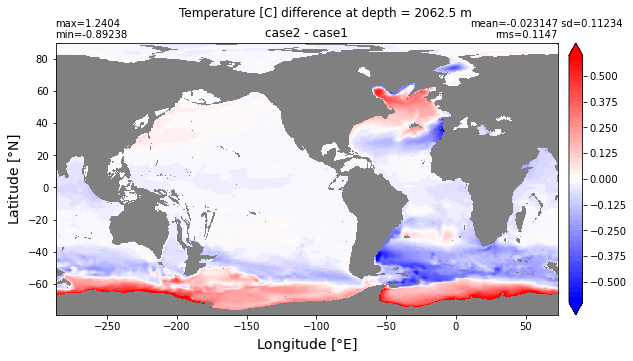

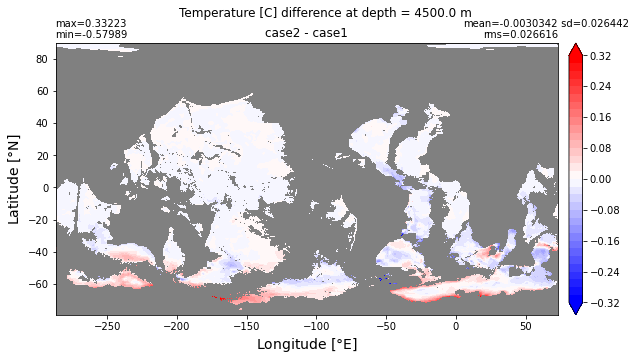

In [46]:
%matplotlib inline
# change kall to see bias at other depths
kall=[0,1,2,3,5,10,15,20,22,25,30]

for k in kall:
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
  temp_mom1 = np.ma.masked_invalid(ds1.thetao[k,:].values)
  temp_mom2 = np.ma.masked_invalid(ds2.thetao[k,:].values)
  cmax = np.max(np.abs(temp_mom2)-np.abs(temp_mom1))
  clim = (-cmax, cmax)
        
  xyplot(temp_mom2-temp_mom1, grd.geolon, grd.geolat, grd.area_t, centerlabels=True,
           title=str(labels[1]+' - '+labels[0]), axis=ax, nbins=50, clim=clim,
           colormap=plt.cm.bwr)
  
  plt.suptitle('Temperature [C] difference at depth = {} m' \
              .format(ds1.z_l[k].values))  

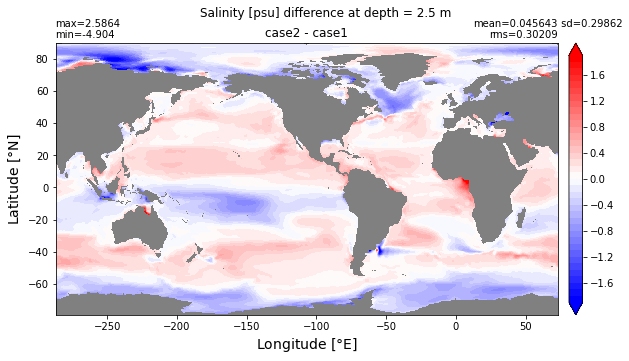

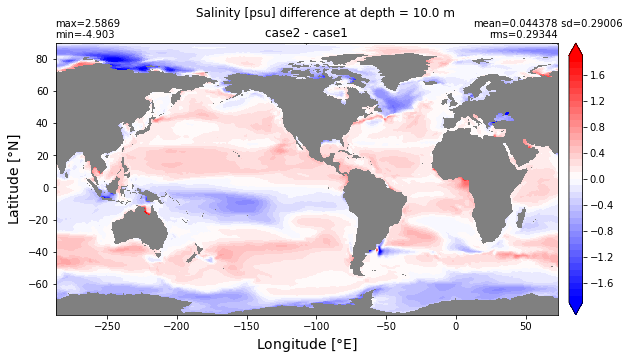

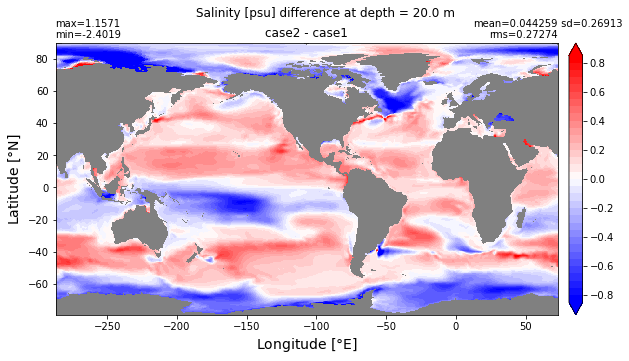

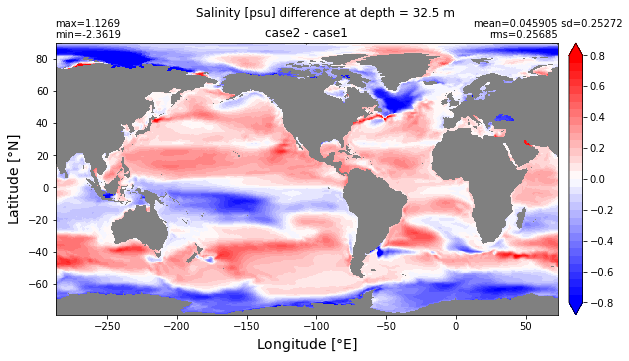

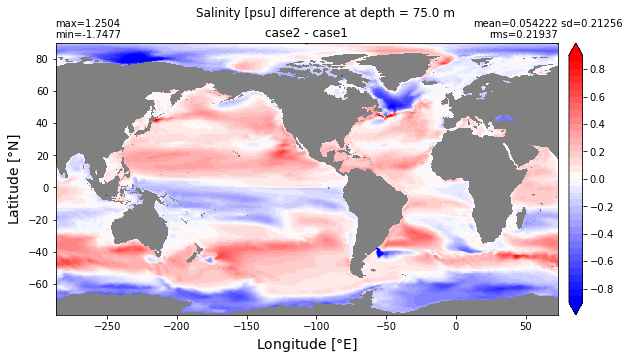

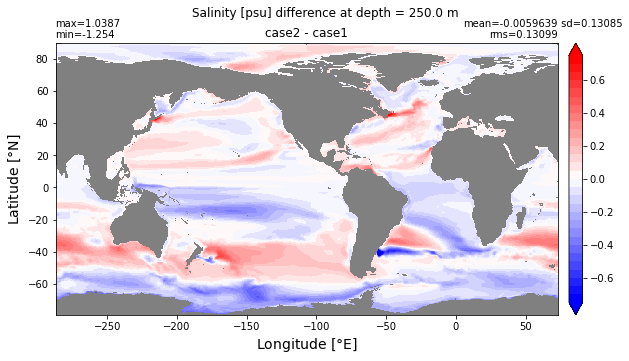

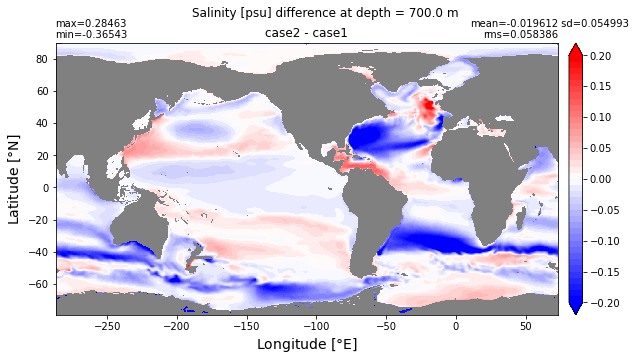

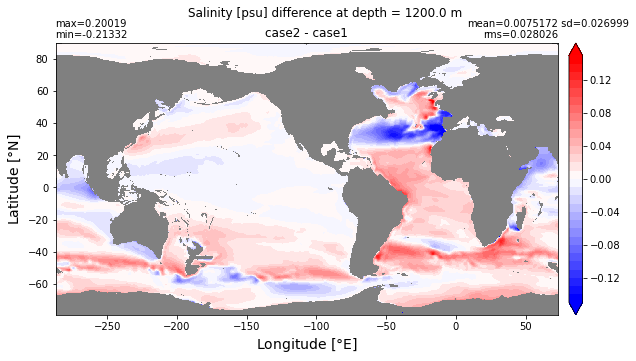

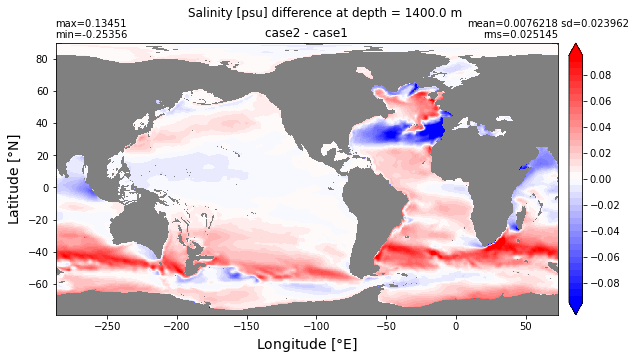

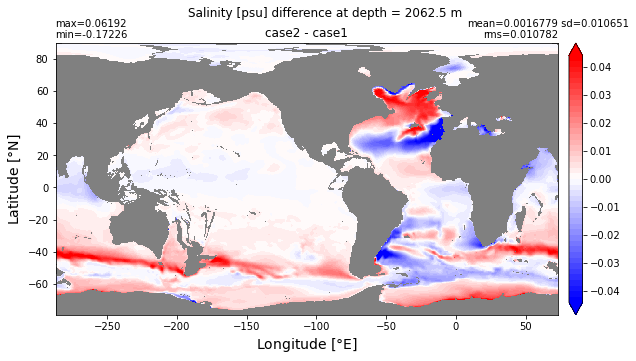

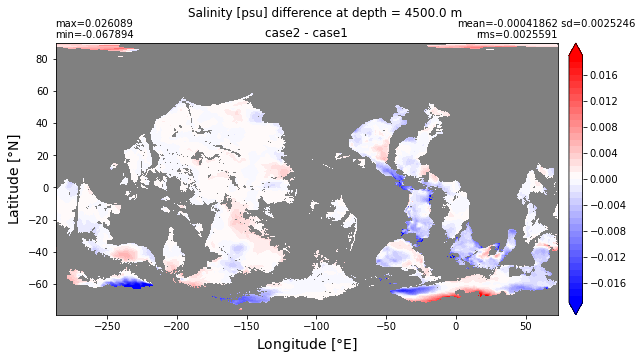

In [47]:
%matplotlib inline
# change kall to see bias at other depths
kall=[0,1,2,3,5,10,15,20,22,25,30]

for k in kall:
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
  salt_mom1 = np.ma.masked_invalid(ds1.so[k,:].values)
  salt_mom2 = np.ma.masked_invalid(ds2.so[k,:].values)
  cmax = np.max(np.abs(salt_mom2)-np.abs(salt_mom1)) * 0.7
  clim = (-cmax, cmax)
        
  xyplot(salt_mom2-salt_mom1, grd.geolon, grd.geolat, grd.area_t, centerlabels=True,
           title=str(labels[1]+' - '+labels[0]), axis=ax, nbins=50, clim=clim,
           colormap=plt.cm.bwr)
  
  plt.suptitle('Salinity [psu] difference at depth = {} m' \
              .format(ds1.z_l[k].values))  

### Boundary layer depth

In [49]:
def preprocess(ds):
  ''' Compute montly averages and return the dataset with variables'''
  variables=['oml']
  return ds[variables].sel(time=slice(start, end))

bld = []
for i in range(len(exps)):
  print(i)
  files = sorted(glob.glob(path+exps[i]+'/run/'+exps[i]+'.mom6.hm_*.nc'))[0:-1]

  ds = xr.open_mfdataset(files,
        parallel=True,
        concat_dim="time",
        combine="nested",
        preprocess=preprocess,
        chunks={'time': 1},).mean('time').compute()
    
  bld.append(ds)

0
1


In [50]:
bld[0]

<xarray.Dataset>
Dimensions:  (yh: 458, xh: 540)
Coordinates:
  * yh       (yh) float64 -79.2 -79.08 -78.95 -78.82 ... 87.55 87.64 87.71 87.74
  * xh       (xh) float64 -286.7 -286.0 -285.3 -284.7 ... 70.67 71.33 72.0 72.67
Data variables:
    oml      (yh, xh) float32 nan nan nan nan nan nan ... nan nan nan nan nan

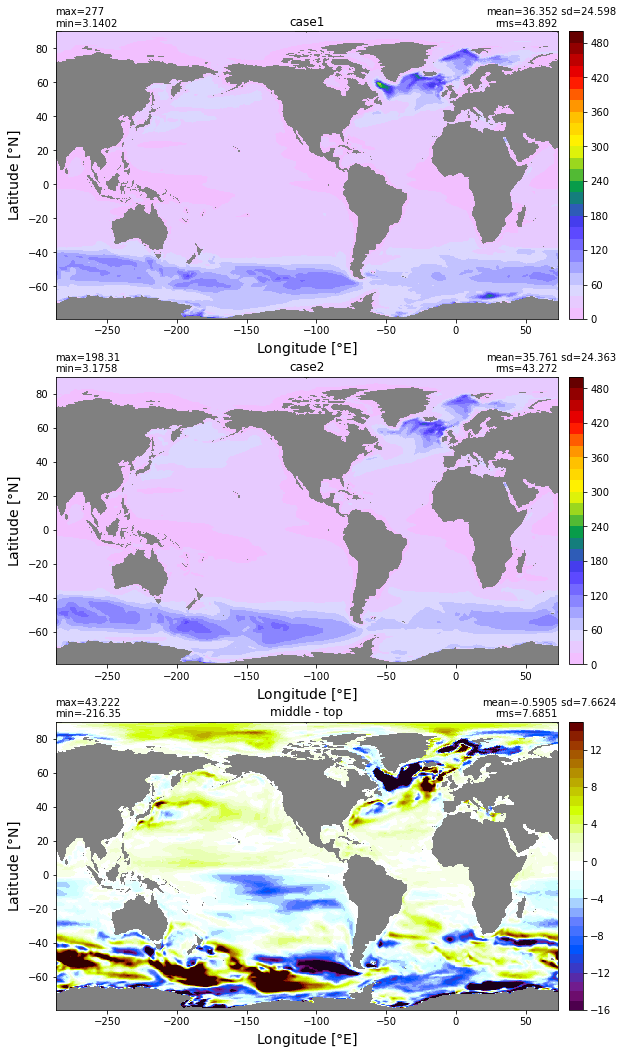

In [51]:
# BLD 
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,18))

top = np.ma.masked_invalid(bld[0]['oml'][:].values)
middle = np.ma.masked_invalid(bld[1]['oml'][:].values)
bottom = middle - top
xyplot(top, grd.geolon, grd.geolat, area=grd.area_t, clim=(0,500), 
       title=str(labels[0]),axis=ax[0])
xyplot(middle, grd.geolon, grd.geolat, area=grd.area_t, clim=(0,500), 
       title=str(labels[1]),axis=ax[1])
xyplot(bottom, grd.geolon, grd.geolat, area=grd.area_t,  
       title='middle - top',axis=ax[2])

In [52]:
client.close()